# Image Classification

In [1]:
# %cd /content/drive/MyDrive/Colab Notebooks/kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
%cd /content/drive/MyDrive/Colab Notebooks/Projects/Image Classification Deep Learning
# !kaggle datasets download -d oossiiris/hackerearth-deep-learning-challenge-holidayseason

/content/drive/MyDrive/Colab Notebooks/Projects/Image Classification Deep Learning


In [2]:
# !unzip hackerearth-deep-learning-challenge-holidayseason

## Importing Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras import optimizers

import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("mako", as_cmap=True)


## Loading the training data

In [4]:
# loading and viewing the data
df = pd.read_csv('train.csv')
train_images = '/content/drive/MyDrive/Colab Notebooks/Projects/Image Classification Deep Learning/train'
test_images = '/content/drive/MyDrive/Colab Notebooks/Projects/Image Classification Deep Learning/test'
display(df.head())
print('\n')

# checking the distribution of the data
print('\033[1m' + '- The dimensions of the training data are: {}'.format(df.shape) + '\033[1m')
print('\n')


,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous




- The dimensions of the training data are: (6469, 2)




## Exploratory Data Analysis

- To get a better idea of how the training data is distributed, lets explore the data further with descriptive and visual analysis.

In [5]:
# checking for missing values in class column
df.isna().sum()
print('\033[1m' + '- The dataset does not have any missing values' + '\033[1m')

- The dataset does not have any missing values


- The samples are distributed in classes as follows: 


,Image
Class,
Miscellaneous,2801
Christmas_Tree,1539
Jacket,640
Candle,593
Airplane,535
Snowman,361


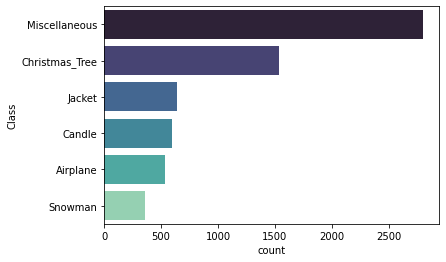

In [6]:
# visualizing the distribution of classes
print('\033[1m' + '- The samples are distributed in classes as follows: ' + '\033[1m')
display(df.groupby('Class').count().sort_values(by = 'Image', ascending = False))
print('\n')
_ = sns.countplot(y = 'Class',palette = 'mako', data = df, order = df['Class'].value_counts().index)

## Splitting the *dataset*

In [7]:
# splitting the data
train_df, validation_df = train_test_split(df, 
                                           test_size = 0.2, 
                                           stratify = df.Class.values, 
                                           shuffle = True, random_state = 42)
train_df.reset_index(inplace = True, drop = True)
validation_df.reset_index(inplace = True, drop = True)

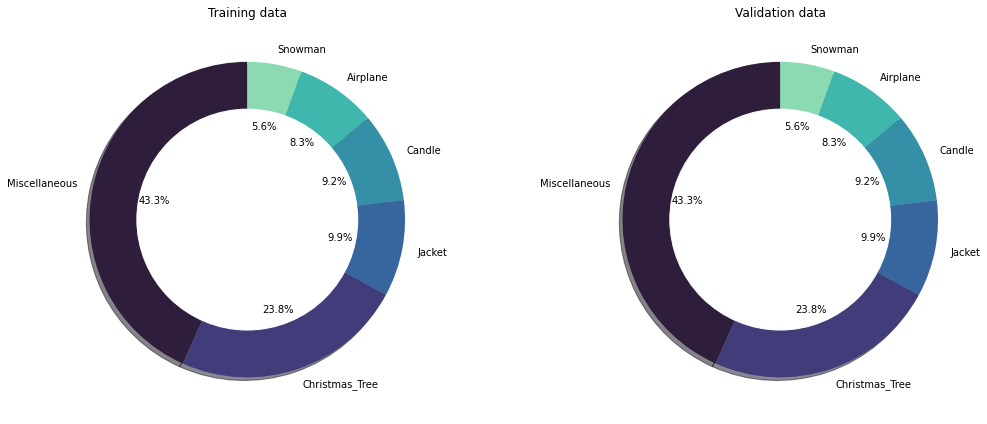

In [8]:
# visualizing the distribution of classes in training vs validation data
def donut_plot(df, col, title, ax, color = sns.color_palette("mako"), labels = None):
  data = df[col].value_counts()
  if labels is None:
    labels = data.index
  ax.pie(data, colors = color, autopct = '%1.1f%%', shadow = True,
         startangle = 90, labels = labels)
  circle = plt.Circle((0,0), 0.7, color = 'white')
  ax.add_artist(circle)
  ax.set_title(title)
  plt.tight_layout()

fig, axs = plt.subplots(1,2, figsize = (18, 6))

donut_plot(train_df, 'Class', title = 'Training data', ax = axs[0])
donut_plot(validation_df, 'Class', title = 'Validation data', ax = axs[1])

## Image Preprocessing

In [9]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

valid_gen = ImageDataGenerator(rescale = 1./255)

training_set = train_gen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_images,
    x_col = 'Image',
    y_col = 'Class',
    class_mode = 'categorical',
    target_size = (299, 299),
    batch_size = 32
)

validation_set = valid_gen.flow_from_dataframe(
    dataframe = validation_df,
    directory = train_images,
    x_col = 'Image',
    y_col = 'Class',
    class_mode = 'categorical',
    target_size = (299, 299),
    batch_size = 32
)

Found 5175 validated image filenames belonging to 6 classes.
Found 1294 validated image filenames belonging to 6 classes.


## Loading the model

In [10]:
conv_base = InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (299, 299, 3)
)

conv_base.summary()

219070464/219055592 [==============================] - 5s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)  

In [ ]:
batch_size = 32
def extract_features(generator, sample_count):
  features = np.zeros(shape = (sample_count, 8, 8, 1536))
  labels = np.zeros(shape = (sample_count, 6))
  i = 0
  for input_batch, labels_batch in generator:
    features_batch = conv_base.predict(input_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(training_set, 5175)
validation_features, validation_labels = extract_features(validation_set, 1294)

In [ ]:
# flattening the extracted features
train_features = np.reshape(train_features, (5175, 8 * 8 * 1536))
validation_features = np.reshape(validation_features, (1294, 8 * 8 * 1536))

# adding the densely connected classifier
model = Sequential()
model.add(Dense(256, activation = 'relu', input_dim = 8 * 8 * 1536))
model.add(Dropout(0.5))
model.add(Dense(6, activation = 'softmax'))
model.summary()

# compiling the model
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy'])

# fitting the model
history = model.fit(
    train_features, train_labels,
    epochs = 30,
    batch_size = 32,
    validation_data = (validation_features, validation_labels)
)

In [ ]:
# plotting the results
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['acc']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# accuracy plots
plt.plot(epochs, train_acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training vs Validation accuracy')
plt.legend()

plt.figure()

# loss plots
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training vs Validation loss')
plt.legend()

plt.show()

### Predicting on the test set

In [ ]:
from keras.applications.imagenet_utils import CLASS_INDEX
name = []
y_pred = []
